In [1]:
from Architectures.VAE import VAE
from Data.load import load
from matplotlib import pyplot as plt
import numpy as np

In [2]:
train, test = load("Pre-processed", take=50)

Loading images:   0%|          | 0/50 [00:00<?, ?it/s]

Loading images: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


In [3]:
ae = VAE(train.shape,halvings=4, latent_dim=300, output_activation="tanh")

Interpreted image shape: (80, 96, 80, 1)
Pre-flattened latent shape: (None, 5, 6, 5, 64)



Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80, 96, 80, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 300), (None,   │     5,833,512 │
│                                 │ 300), (None, 300)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 80, 96, 80, 1)  │     3,073,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,906,617 (33.98 MB)

 Trainable params: 8,906,617 (33.98 MB)

 Non-trainable params: 0 (0.00 B)

-0.4961083691975153 0.8726422589210117


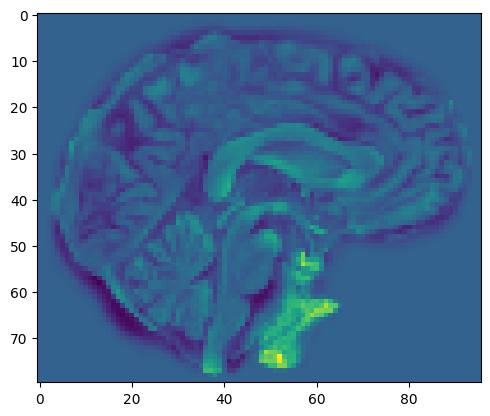

In [3]:
# Train on the diff to the mean brain instead
mean_brain = np.mean(train, axis=0)
diff_train = train - mean_brain
diff_test = test - mean_brain
plt.imshow(np.rot90(diff_train[0][40]))
print(np.min(diff_train), np.max(diff_train))

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Model
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling function for the reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * logvar) * epsilon

latent_dim = 20
# Define the VAE model
class VAE(keras.Model):
    def __init__(
            self,
            input_shape,
            halvings=4,
            init_hidden_depth=8,
            latent_dim=1_000,
            output_activation="tanh",
            lambda_=1e-5,
            hidden_activation=activations.leaky_relu
            ):
        super(VAE, self).__init__()
        self.lambda_ = lambda_

        shape_changed=False
        if input_shape[-1]>3:
            input_shape = list(input_shape) + [1]
            shape_changed=True
        if len(input_shape)>4:
            input_shape = input_shape[-4:]
            shape_changed=True
        if shape_changed: print(f"Interpreted image shape: {tuple(input_shape)}")

        # Encoder
        encoder_input = x = layers.Input(shape=input_shape)
        depth = init_hidden_depth
        for _ in range(halvings):
            x = layers.Conv3D(depth, (3, 3, 3), strides=2, activation=hidden_activation, padding="same")(x)
            x = layers.Dropout(0.05)(x)
            depth <<= 1

        pre_flatten_shape = x.shape
        print(f"Pre-flattened latent shape: {pre_flatten_shape}")
        x = layers.Flatten()(x)
        
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        
        self.encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(latent_dim,))
        x = layers.Dense(pre_flatten_shape[1] * pre_flatten_shape[2] * pre_flatten_shape[3] * pre_flatten_shape[4], activation="relu")(decoder_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)
        
        for _ in range(halvings):
            depth >>= 1
            x = layers.Conv3D(depth, (3, 3, 3), activation=hidden_activation, padding="same")(x)
            x = layers.UpSampling3D((2, 2, 2))(x)
        decoded = layers.Conv3D(1, (3, 3, 3), activation=output_activation, padding="same")(x)
        self.decoder = Model(decoder_input, decoded, name="decoder")
        
    def call(self, inputs):
        z, mu, logvar = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*self.lambda_
        self.add_loss(kl_loss)
        return reconstructed

# Instantiate the VAE model
vae = VAE(train.shape,latent_dim=latent_dim,halvings=3, lambda_=5e-4)
vae.compile(optimizer=keras.optimizers.Adam(), loss="mse")

Interpreted image shape: (80, 96, 80, 1)
Pre-flattened latent shape: (None, 10, 12, 10, 32)


In [56]:
vae.fit(train, train, epochs=40, batch_size=100, verbose=True)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2154
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2884
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1536
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1858
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1498
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1261
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1495
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1189
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1245
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1299
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1231
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1152
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1085
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1102
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1145
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1152
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


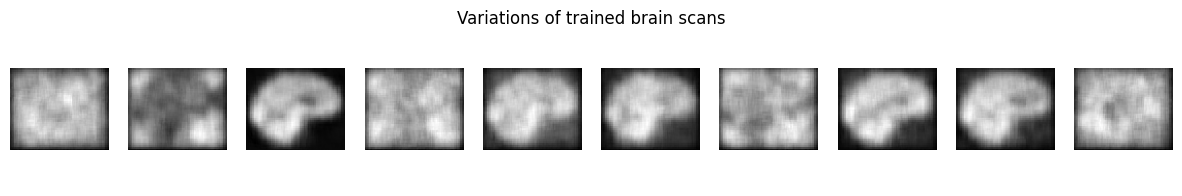

In [57]:
num_samples = 10
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
generated_images = vae.decoder.predict(random_latent_vectors)

plt.figure(figsize=(15, 2))
plt.title("Variations of trained brain scans")
plt.axis("off")
for i in range(num_samples):
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(np.rot90(generated_images[i,40,:,:]), cmap="gray")
    ax.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


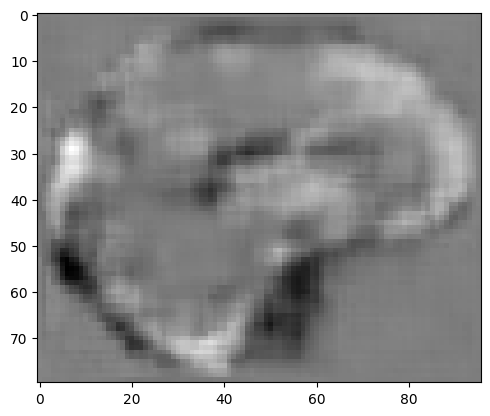

In [ ]:
latent = ae.encode(diff_test)
recon = ae.decode(latent)
plt.imshow(np.rot90(recon[0][40]),cmap="gray")

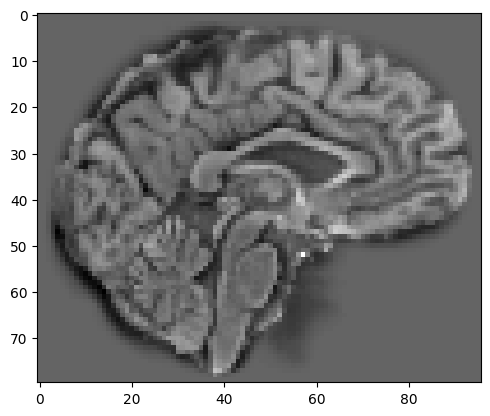

In [ ]:
plt.imshow(np.rot90(diff_test[0][40].reshape((96,80))),cmap="gray") # mean_brain[40]+

In [ ]:
from Metrics.metrics import NMSE, SSIM
SSIM(recon.reshape(diff_test.shape), diff_test)

0.47985097879764366